<a href="https://colab.research.google.com/github/beckslopez/Music-Generation-and-Classification-Using-NNs/blob/main/Music_Generation_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import librosa #librosa for audio processing
import librosa.display

import numpy as np
import csv
import pandas as pd
import os

import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from IPython import display
from IPython.display import clear_output

import glob
import imageio
import time
import IPython.display as ipd

import zipfile
# import music21
from sklearn.model_selection import train_test_split
import skimage.io

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
# import wav file information pre-processed into a csv

from google.colab import drive
drive.mount('/content/drive')
# !cp "/content/drive/My Drive/563 Project Files/reggae_wav_files.csv" "/content"

Mounted at /content/drive


In [ ]:
reggae_fl = pd.read_csv('reggae_wav_files.csv')
reggae_fl.shape

(100, 300002)

In [ ]:
reggae_lib_dat = reggae_fl.drop('Unnamed: 0',axis=1).drop('genre',axis=1)

In [ ]:
#Split into training and test sets

train, test = train_test_split(reggae_lib_dat, test_size=0.1)

In [ ]:
#Save these for later in case colab crashes

train.to_csv('/content/drive/My Drive/563 Project Files/reggae_train.csv')
test.to_csv('/content/drive/My Drive/563 Project Files/reggae_test.csv')

In [ ]:
#pull out a validation set

train_dat = train.iloc[:, :-10000]
val_dat = train.iloc[:, -10000:]

In [ ]:
# train = pd.read_csv('/content/drive/My Drive/563 Project Files/reggae_train.csv')
test = pd.read_csv('/content/drive/My Drive/563 Project Files/reggae_test.csv')
# train_dat = train.iloc[:, 1:-10000]
# val_dat = train.iloc[:, -10000:]

In [ ]:
train_dat.shape

(90, 290000)

In [ ]:
# Process training data into more manageable chunks
train_data_batches = np.zeros((29*train_dat.shape[0],10000))

for n in np.arange(train_dat.shape[0]):
  for m in np.arange(29):
      train_data_batches[n+m,:] = train_dat.iloc[n, m*10000:(m+1)*10000]

In [ ]:
train_data_batches.shape[0]

2610

In [ ]:
#RNN definition

class CustomNetwork(nn.Module):
  def __init__(self, input_size=1,conv_len = 365,dilat=11, hidden_size=100,output_len=1000):
      
    super(CustomNetwork, self).__init__()
    self.hidden_layer_size = hidden_size
    self.output_len=output_len

    #convolution layer to reduce number of paramaters necessary
    self.conv1 = nn.Conv1d(input_size, input_size,dilation=dilat, kernel_size=conv_len,stride=5)
    
    # Biderectional GRU layer
    self.lstm = nn.GRU(input_size, hidden_size, batch_first=True,bidirectional=True)

    #dropout to aid training 
    self.drop = nn.Dropout(0.1)

    #linear layer to produce a 1D output 
    self.linear = nn.Linear(hidden_size*2, 1)

  def forward(self, input_seq):
    hidden_0 = torch.zeros(2,input_seq.shape[0],self.hidden_layer_size).requires_grad_(requires_grad=True).to(device)#, 
                #torch.zeros(2,input_seq.shape[0],self.hidden_layer_size).requires_grad_(requires_grad=True).to(device))
    working_seq = self.conv1(input_seq)
    working_seq =torch.transpose(working_seq, 1, 2)
    lstm_out, hidden_n = self.lstm(working_seq, hidden_0)
    lstm_out= self.drop(lstm_out)
    prediction = self.linear(lstm_out.view(-1,self.output_len,2*self.hidden_layer_size))
    return prediction[:,:,0]

In [ ]:
#dataloaders

my_x = train_data_batches[:,:9000]
my_y = train_data_batches[:,9000:] 

tensor_x = torch.Tensor(my_x).view(-1,1,9000)
tensor_y = torch.Tensor(my_y).view(-1,1,1000)

reggae_dataset = TensorDataset(tensor_x,tensor_y) 
reggae_dataloader = DataLoader(reggae_dataset,batch_size=29)

In [ ]:
val_np = val_dat.dropna().to_numpy()
my_x =  val_np[:,:9000] # a list of numpy arrays
my_y = val_np[:,9000:] # another list of numpy arrays (targets)

tensor_x = torch.Tensor(my_x).view(-1,1,9000) # transform to torch tensor
tensor_y = torch.Tensor(my_y).view(-1,1,1000)#.view(train_data_batches.shape[0],1,1000)

val_dataset = TensorDataset(tensor_x,tensor_y) 
val_loader = DataLoader(val_dataset,batch_size=10) 

In [ ]:
#initialize model and establish training length, loss, and optimizer 
max_epochs = 1001
model = CustomNetwork().to(device)
model.load_state_dict(torch.load('/content/drive/My Drive/563 Project Files/reggae_model_fin_state_fin.pt', map_location=device))
print(next(model.parameters()).is_cuda)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
training_loss = np.zeros(max_epochs)
val_loss = np.zeros(max_epochs)

True


In [ ]:
# Training

for i in range(max_epochs):
  for batch, (train_features, train_labels) in enumerate(reggae_dataloader): #train_sample in train_loader:

        #train_features, train_labels = next(iter(train_loader))
    xtrain = train_features.reshape((29,1,9000)).to(device)
    optimizer.zero_grad()
    ypred_train = model(xtrain)

    loss = criterion(ypred_train, train_labels.reshape((29,1000)).to(device))
    training_loss[i] += loss.item()

    loss.backward()
    optimizer.step()

  with torch.no_grad():
    for batch, (val_features, val_labels) in enumerate(val_loader):#val_sample in test_loader:
    #         #val_features, val_labels = next(iter(test_loader))
      xval = val_features.reshape((-1,1,9000)).to(device)
      ypred_val = model(xval)
      valloss = criterion(ypred_val, val_labels.reshape((-1,1000)).to(device))
      val_loss[i] +=valloss
  if i%100==0:
    print("The training error is: "+str(training_loss[i]))
    print("The validation error is: "+str(val_loss[i]))
  if i%500==0:
    torch.save(model.state_dict(), "/content/drive/My Drive/563 Project Files/reggae_model_fin_state_"+str(i)+".pt")


The training error is: 0.1369590483882348
The validation error is: 0.17576447129249573
The training error is: 0.0884348670801085
The validation error is: 0.17771603167057037
The training error is: 0.07866819034964578
The validation error is: 0.20849640667438507
The training error is: 0.07270707138923171
The validation error is: 0.21636293828487396
The training error is: 0.0710626359999651
The validation error is: 0.2580937445163727
The training error is: 0.06526856334727427
The validation error is: 0.2277371883392334
The training error is: 0.06783817204996012
The validation error is: 0.24316930770874023
The training error is: 0.05930397143265509
The validation error is: 0.22615906596183777
The training error is: 0.05455845655058056
The validation error is: 0.20749224722385406
The training error is: 0.05193475274393222
The validation error is: 0.23703144490718842
The training error is: 0.046871970888332726
The validation error is: 0.2171531319618225


In [ ]:
#execute final model save

torch.save(model.state_dict(), "/content/drive/My Drive/563 Project Files/reggae_model_fin_state_fin.pt")
torch.save(model, "/content/drive/My Drive/563 Project Files/reggae_model_fin_fin.pt")

In [ ]:
np.save("/content/drive/My Drive/563 Project Files/reggae_model_fin_training_err.npy",training_loss)
val_loss_2 = np.array([j.item() for j in val_loss])
np.save("/content/drive/My Drive/563 Project Files/reggae_model_fin_val_err.npy",val_loss_2)

In [ ]:
# !cp '/content/drive/My Drive/563 Project Files/pop_test.csv' '/content'
# test =pd.read_csv('reggae_test.csv')

In [ ]:
samp = test.iloc[1,1:9001]

In [ ]:
ypred_test = np.zeros(59000)
ypred_test[:9000] = samp.values

In [ ]:
for n in np.arange(50):
  ypred_test[9000+(n*1000):9000+((n+1)*1000) ]=model(torch.Tensor(ypred_test[n*1000:n*1000+9000]).reshape((1,1,9000)).to(device)).cpu().detach().numpy()

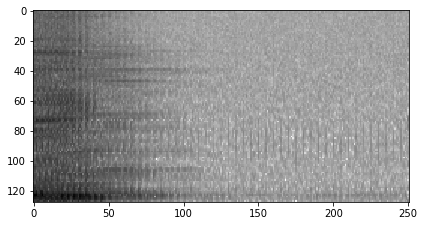

In [ ]:
#mel spectrogram example

spectrogram_image(ypred_test[9000:])#,out='/content/drive/My Drive/563 Project Files/model_5_pop_output/draft_song_5_9.png')

In [ ]:
#audio clip example

ipd.Audio(ypred_test,rate=10000)

In [ ]:
ipd.Audio(test.iloc[1,:],rate=10000)

In [ ]:
#functions for viewing and saving mel spectrograms

def scale_minmax(X, min=0.0, max=1.0):
  X_std = (X - X.min()) / (X.max() - X.min())
  X_scaled = X_std * (max - min) + min
  return X_scaled

def spectrogram_image(y, out,hop_length=200,n_mels=128,sr=10000):
    # use log-melspectrogram
  mels = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels,
                                            n_fft=hop_length*2, hop_length=hop_length)
  mels = np.log(mels + 1e-9) # add small number to avoid log(0)

    # min-max scale to fit inside 8-bit range
  img = scale_minmax(mels, 0, 255).astype(np.uint8)
  img = np.flip(img, axis=0) # put low frequencies at the bottom in image
  img = 255-img # invert. make black==more energy

    # save as PNG
  skimage.io.imsave(out, img)
  # skimage.io.imshow(img)

In [ ]:
for x in np.arange(10):
  samp = test.iloc[x,1:9001]
  ypred_test = np.zeros(59000)
  ypred_test[:9000] = samp.values
  for n in np.arange(50):
    ypred_test[9000+(n*1000):9000+((n+1)*1000) ]=model(torch.Tensor(ypred_test[n*1000:n*1000+9000]).reshape((1,1,9000)).to(device)).cpu().detach().numpy()
  spectrogram_image(ypred_test[9000:],out='/content/drive/My Drive/563 Project Files/fin_reggae_model_output/reggae_out_'+str(x)+'.png')